# < 뉴스 요약봇 만들기 >

**- 목차 -**

□ Step1 데이터 수집하기   
□ Step2 데이터 전처리하기(추상적 요약)   
□ Step3 어텐션 메커니즘 사용하기 (추상적 요약)  
□ Step4 실제 결과와 요약문 비교하기 (추상적 요약)   
□ Step5 Summa을 이용해서 추출적 요약해보기  
□ 정리 및 회고

### ■ Step1 데이터 수집하기

**1-1 필요한 라이브러리 import**

In [40]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**1-2 데이터 다운로드**

- 뉴스 기사 데이터 : [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

In [41]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [44]:
data.sample(10)

,headlines,text
62679,Windies' Chanderpaul signs new county deal at ...,Former Windies' batsman Shivnarine Chanderpaul...
56346,Bail plea of Ryan school murder accused rejected,The Juvenile Justice Board on Friday rejected ...
20126,Ready for a possible trade war with US: Alibaba,Chinese e-commerce giant Alibaba's Vice Chairm...
3271,200 policemen go to Karnataka village to catch...,Around 200 police personnel went to Karnataka'...
95476,Release date of Salman Khan's film 'Tubelight'...,The Salman Khan starrer upcoming film 'Tubelig...
91787,Arijit took part in reality singing show befor...,Singer Arijit Singh participated in reality si...
38347,Afghanistan reduce India to 347/6 from 280/2 o...,Afghanistan reduced India to 347/6 from 280/2 ...
16780,SC summons Delhi BJP Chief for breaking lock o...,The Supreme Court issued a contempt notice to ...
2206,Ex-Goa Ranji cricketer Ghodge dies at 43 after...,"Former Ranji cricketer Rajesh Ghodge, who repr..."
97218,US girl sexually assaulted as 40 watched on Fa...,"A 15-year-old girl in Chicago, US was sexually..."


- 'news_summary_more.csv' 데이터는 기사의 본문에 해당되는 text와 headlines이 각각 98401개씩 두 가지 열로 구성되어져 있음 

### ■ Step2 데이터 전처리하기(추상적 요약)

**2-1 중복을 배제한 유일한 샘플의 수 확인**

In [45]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


**2-2 중복 샘플 제거**

In [46]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적 수정
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


**2-3 Null값 확인**

In [47]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


**2-4 텍스트 정규화 사전 구성**

In [48]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


**2-5 NLTK 불용어 리스트 생성**

In [49]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

**2-6 데이터 전처리 함수 생성**

In [50]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

**2-7 멀티프로세싱 데이터 전처리 함수 생성**

In [51]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

**2-8 멀티프로세싱 데이터 전처리 실시**

In [52]:
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False)
print(clean_headlines)

clean_text = preprocess_data(data['text'])
print(clean_text)

12.732669115066528  seconds
['upgrad learner switches to career in ml al with salary hike'
 'delhi techie wins free food from swiggy for one year on cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'the matrix film to get reboot reports'
 'snoop dogg aims gun at clown dressed as trump in new video'
 'madhesi morcha withdraws support to nepalese government']
429.9837040901184  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated in

**2-9 데이터 전처리 후 빈(empty) 샘플이 생겼는지 확인하고 Null값으로 변환**

In [53]:
data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

**2-10 Null값 유무 다시 확인**

In [54]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

**2-11 샘플의 최대 길이를 정하기 위해 데이터 길이 분포 시각화**

headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534
text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221


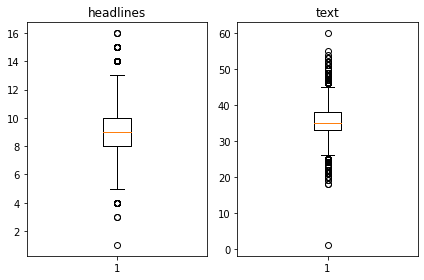

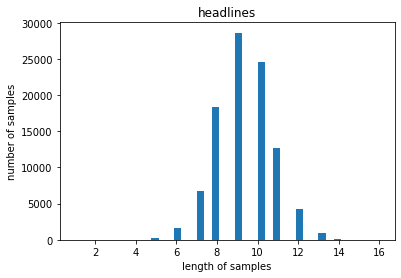

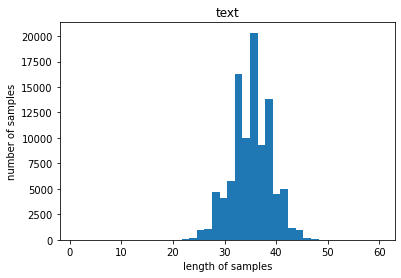

In [55]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 많은 양의 데이터를 다룰 때는 시각화하여 보는 것이 좋음
- headlines는 최소 길이가 1, 최대길이가 16, 평균 길이가 9임
- text는 최소 길이가 1, 최대 길이가 60, 평균 길이가 35임

**2-12 샘플길이 임의 설정**

In [59]:
headlines_max_len = 10
text_max_len = 40
print('=3')

=3


**2-13 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수 생성**

In [60]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


**2-14 임의로 설정한 샘플의 길이가 몇 %의 샘플까지 포함하는지 확인**

In [61]:
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165


**2-15 정해진 길이보다 긴 샘플 제외**

In [62]:
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


**2-16 시작 토큰과 종료 토큰 추가하기**

In [63]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


**2-17 인코더 입력, 디코더 입력, 디코더 레이블 Numpy 타입으로 저장**

In [64]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


**2-18 훈련 데이터와 테스트 데이터 분리**

In [65]:
# encoder_input과 크기, 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스로 데이터 샘플 순서 정의하여 샘플 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 전체 데이터 중 20%만큼을 테스트 데이터 크기로 정의
n_of_val = int(len(encoder_input)*0.2)

# 테스트 데이터 개수를 이용해서 전체 데이터를 훈련 데이터와, 테스트 데이터로 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


**2-19 encoder_input_train 단어 집합 만들기(text 데이터)**

In [66]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


**2-20 단어집합 통계정보 확인**

In [67]:
threshold = 7 # 등장 횟수 7회 미만 
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61482
등장 빈도가 6번 이하인 희귀 단어의 수: 42167
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19315
단어 집합에서 희귀 단어의 비율: 68.58430109625581
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.187118330480672


- `encoder_input_train`에는 6만1천여개의 단어가 있음
- 등장 빈도가 6회 이하인 단어들은 단어 집합에서 68%를 차지하지만, 실제 훈련 데이터에 등장하는 빈도는 4.1%로 작음
- 따라서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
- 단어 집합의 크기를 19,000개로 제한

**2-21 단어 집함 크기 제한 및 정수 인코딩**

In [68]:
# 단어 집합의 크기를 20,000으로 제한
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[120, 15, 5128, 225, 287, 790, 7396, 10288, 530, 1563, 8453, 2635, 27, 147, 60, 147, 987, 116, 691, 225, 106, 4502, 4259, 1074, 86, 726, 116, 154, 7, 413, 147, 746, 673], [56, 609, 1658, 1452, 9035, 391, 3066, 40, 100, 1060, 1031, 2962, 988, 13146, 74, 1261, 237, 1, 9036, 642, 1261, 219, 925, 3816, 4345, 560, 1452, 4, 10641, 182, 1902, 12184, 875], [38, 677, 2750, 420, 198, 65, 9486, 51, 48, 2526, 734, 3164, 6139, 1746, 614, 3211, 39, 5961, 4384, 178, 556, 7, 305, 38, 1, 39, 5961, 1785, 178, 223, 475]]


**2-22 decoder_input_train 단어 집합 만들기(headlines 데이터)**

In [69]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


**2-23 단어집합 통계정보 확인**

In [70]:
threshold = 6 # 등장횟수 6회 미만
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27216
등장 빈도가 5번 이하인 희귀 단어의 수: 18183
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9033
단어 집합에서 희귀 단어의 비율: 66.80996472663139
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.973030337867169


- 등장 빈도가 5회 이하인 단어들은 단어 집합에서 66%를 차지하고 있지만, 실제 훈련 데이터에서 등장 빈도는 5.9%로 낮음
- 어림잡아 9000을 단어 집합의 크기로 제한

**2-24 단어 집함 크기 제한 및 정수 인코딩**

In [71]:
# 단어 집합의 크기를 9,000으로 제한
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 294, 170, 2401, 10, 106, 534, 13, 23, 270], [1, 167, 16, 6986, 3, 544, 70, 251, 927, 2598, 644], [1, 30, 20, 2599, 226, 10, 106, 850, 3, 2251, 4302], [1, 20, 61, 5, 3120, 539, 12, 1227, 3, 42], [1, 53, 1818, 6476, 2054, 264, 48, 2812, 2455, 731]]
target
decoder  [[294, 170, 2401, 10, 106, 534, 13, 23, 270, 2], [167, 16, 6986, 3, 544, 70, 251, 927, 2598, 644, 2], [30, 20, 2599, 226, 10, 106, 850, 3, 2251, 4302, 2], [20, 61, 5, 3120, 539, 12, 1227, 3, 42, 2], [53, 1818, 6476, 2054, 264, 48, 2812, 2455, 731, 2]]


**2-25 hedlines에서 길이가 0이 된 샘플들 제거**

In [72]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14819
테스트 레이블의 개수 : 14819


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


**2-26 정해둔 최대 길이로 패딩하기**

In [73]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### ■ Step3 어텐션 메커니즘 사용하기 (추상적 요약)

**3-1 함수형 API를 이용해 인코더 설계**

In [74]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

**3-2 디코더 설계**

In [75]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

**3-3 모델 정의**

In [76]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

**3-4 어텐션 함수 다운로드**

In [77]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

**3-5 어텐션 함수를 이용해 설계한 디코더의 출력층 수정 및 모델 재정의**

In [78]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

**3-6 모델 훈련하기**

In [79]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  # 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈춤
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 529s 2s/step - loss: 6.6706 - val_loss: 5.9429
Epoch 2/50
232/232 [==============================] - 282s 1s/step - loss: 5.8653 - val_loss: 5.5326
Epoch 3/50
232/232 [==============================] - 165s 713ms/step - loss: 5.4935 - val_loss: 5.2439
Epoch 4/50
232/232 [==============================] - 166s 716ms/step - loss: 5.1772 - val_loss: 5.0301
Epoch 5/50
232/232 [==============================] - 166s 714ms/step - loss: 4.9272 - val_loss: 4.8775
Epoch 6/50
232/232 [==============================] - 165s 712ms/step - loss: 4.7236 - val_loss: 4.7339
Epoch 7/50
232/232 [==============================] - 165s 711ms/step - loss: 4.5371 - val_loss: 4.6346
Epoch 8/50
232/232 [==============================] - 166s 715ms/step - loss: 4.3734 - val_loss: 4.5387
Epoch 9/50
232/232 [==============================] - 165s 712ms/step - loss: 4.2313 - val_loss: 4.4630
Epoch 10/50
232/232 [==============================] - 165s 710ms/step

**3-7 훈련과정 시각화**

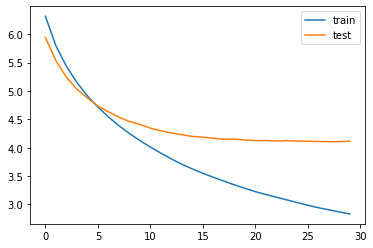

In [80]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### ■ Step 4 실제 결과와 요약문 비교하기 (추상적 요약)

**4-1 정수 인덱스 행렬을 실제 데이터로 복원하기위한 3개의 사전 준비**

In [81]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

**4-2 인퍼런스(실전 요약)를 위한 모델 설계**

In [82]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

**4-3 어텐션 메커니즘을 사용하는 출력층 설계**

In [83]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**4-4 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 생성**

In [87]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

**4-5 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 생성**

In [91]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

**4-6 실제 headlines과 추상적 요약 비교**

In [92]:
for i in range(10):
    print("<원문> :", seq2text(encoder_input_test[i]))
    print("[실제 요약] :", seq2headlines(decoder_input_test[i]))
    print("[예측 요약] :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

<원문> : german chancellor angela merkel said collapse talks britain planned exit european union cannot ruled however merkel said germany partners eu putting energy securing deal britain want negotiations collapse german chancellor added 
[실제 요약] : collapse of brexit talks cannot be ruled out germany 
[예측 요약] :  brexit not to be appointed german chancellor merkel


<원문> : ex prime minister manmohan singh said relationship rbi government similar ties husband wife added differences opinion two great institutions must organisations work governor rbi wish well singh said 
[실제 요약] : rbi government are like husband and wife says manmohan singh 
[예측 요약] :  never thought about the manmohan singh


<원문> : london based bp working reliance industries start petrol pumps india begin operations months according reports bp received approval licence set fuel retail outlets october last year bp reliance industries already partners exploration production gas sourcing businesses 
[실제 요약] : to partner with 

### ■ Step 5 Summa을 이용해서 추출적 요약해보기

**5-1 데이터 다운로드**

In [93]:
import requests
from summa.summarizer import summarize


data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

**5-2 실제 headlines과 추출적 요약 비교**

In [95]:
for i in range(10):
    print("<원문> :", data['text'][i])
    print("실제 HEADLINE : ", data['headlines'][i])
    print("추출적 요약 HEADLINE : ", summarize(data['text'][i], ratio=0.5))
    print("\n")

<원문> : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 HEADLINE :  upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 HEADLINE :  upGrad's Online Power Learning has powered 3 lakh+ careers.


<원문> : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 HEADLINE :  Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 HEADLINE :  Users

### ■ 정리 및 회고

**1. 추상적 요약 결과 확인**

**<원문>** : mumbai police monday arrested year old drug addict stealing trophies sports shop accused said sneaked shop steal money stole trophies instead money according police officials arrested day robbery could sell trophies police added

**[실제 HeadLine]** : mumbai man held for stealing trophies from sports shop 

**[예측 요약]** :  mumbai police arrests drug racket

- 원문의 대략적인 내용은 뭄바이 경찰이 월요일에 스포츠 용품점을 훔치는 마약 중독자를 체포한 것이다. 실제 요약은 '스포츠 가게에서 전리품을 훔친 혐의로 붙잡힌 뭄바이 남자'이고, 추상적 요약은 '뭄바이 경찰, 마약 밀매 검거'이다. 마약 밀매가 아니라 마약 중독자를 검거한 것이라 살짝 초첨이 다르긴 하지만 어느 정도 비슷한 키워드로 요약이 잘 된것 같다.

- 위 예시는 핵심 단어나 내용을 잘 포함했지만, 문법적 완성도가 엄청 높지는 않은 것 같다. 그래도 상당히 괜찮은 수준 같다.

- 하지만 그렇지 않은 예시도 있다. 이는 모델 학습 결과 자체가 성능결과가 높지 않고, 원문 길이 자체가 짧아서 인 것 같기도 하다.



**2. 추출적 요약 결과 확인**

**<원문>** : Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll. With this victory, Congress has taken its total to 100 seats in the 200-member assembly. The election to the Ramgarh seat was delayed due to the death of sitting MLA and BSP candidate Laxman Singh.

**[실제 HEADLINE]** :  Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats

**[추출적 요약 HEADLINE]** :  Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.

- 원문의 대략적인 내용은 의회 투표 결과로 의석을 확보한 것이다. 실제 headline은 의석을 차지했다는 내용이고, 추출적 요약 역시 의석을 차지했다는 내용이다. 핵심적인 내용이 잘 요약 된것 같다.

- 위 예시는 핵심 단어나 내용도 잘 포함되었고 문법적 완성도도 괜찮은 것 같다.

- 하지만 그렇지 않은 예시도 있다. 핵심 단어는 잘 포함 했으나 문법적 완성도 수준이 높지 않다.

**3. 노드를 마치며..**

역시 NLP 노드는 쉽지 않다. 전체적인 흐름을 이해하는 것 부터가 어렵고, 모델의 학습 시간도 오래걸려서 답답함이 더 크다. 또한 데이터 전처리의 중요성을 다시 한번 더 느낀다. 데이터를 어떻게 정제할지에 많은 공부가 필요하다. 또한 모델과 모델 설계에 대한 이해도 많이 필요하다. 어텐션 메커니즘데 대해서도 마찬가지이다. 모델의 성능을 더 높이는 다양한 방법들에 대해서도 추후에 시도해 보아야겠다.